In [1]:
import sys
sys.path.append('../60_gebastel/Model/')
sys.path.append('../30_data_tools/')

In [2]:
from io import BytesIO
from pytorch_model_tools import get_datasets
from file_interaction import download_blob
from tqdm.auto import tqdm
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pickle
import math
import pandas as pd
import re
from helper import load_dotenv
import sqlite3
from get_labelstudio_data import get_results_of_project
from load_constants import load_colors

from PIL import Image
from PIL import ImageFont, ImageDraw  
from pathlib import Path

In [3]:
dotenv = load_dotenv()
con = sqlite3.connect( dotenv['DB_PATH'] )

In [4]:
colors = load_colors()

In [324]:
len(real_val_tiles)

6238

In [5]:
real_val_tiles = [tile_path.name for tile_path in (dotenv['TILE_DATASET_DIR'] / 'real_val').glob('./**/*.jpg')]

## noch offen

- ROC-Kurve/Area under Curve

0 = moire, 1 = no moire

# Funktionen

In [6]:
def load_data( model_results_name ):
    data = pickle.loads( download_blob(f'model_results/{ model_results_name }.pkl').getbuffer() )
    data.rename(columns={'category':'label'}, inplace=True)
    
    data.loc[:,'predicted_label'] = (data.result_moire < data.result_no_moire).astype('int').apply(lambda val: ['moire','no_moire'][val])
    data.loc[:,'classification_correct'] = data.predicted_label == data.label

    data = pd.merge(
        data,
        data.tile_name.str.extract('(.+)_(\d+)\.\d+\.jpg').rename(columns={0:'mask_id',1:'dpi'}),
        left_index=True,
        right_index=True
    )
    data.loc[
    pd.isna(data.dpi),
        'dpi'
    ] = data.loc[
        pd.isna(data.dpi)
    ].tile_name.str.extract(
        r'ok_sample_.+_(\d+)_\.\d+\.jpg'
    ).rename(columns={0:'dpi'}).dpi

    # real val tiles filterung
    data = data.loc[
        data.index.isin(
            data.loc[
                (data.tile_name.isin(real_val_tiles) == False) &
                (data.dataset == 'real_val')
            ].index        
        ) == False
    ]
    
    return data

In [7]:
def calc_metrics( data ):
    TP = data.loc[(data.label == 'moire') & (data.predicted_label == 'moire')].shape[0]
    TN = data.loc[(data.label == 'no_moire') & (data.predicted_label == 'no_moire')].shape[0]
    FP = data.loc[(data.label == 'no_moire') & (data.predicted_label == 'moire')].shape[0]
    FN = data.loc[(data.label == 'moire') & (data.predicted_label == 'no_moire')].shape[0]

    out = {
        "count_data" : data.shape[0],
        "TP" : TP,
        "TN" : TN,
        "FP" : FP,
        "FN" : FN,
        "TN-Rate" : 0,
        "TP-Rate" : 0,
        "accuracy" : 0,
        "precision" : 0,
        "recall" : 0
    }
    
    if (FP + TN) > 0:
        out["TN-Rate"] = TN / (FP + TN)

    if (FN + TP) > 0:
        out["TP-Rate"] = TP / (FN + TP)

    if out['count_data'] > 0:
        out["accuracy"] = (TP + TN) / out['count_data']

    if (TP + FP) > 0:
        out["precision"] = TP / (TP + FP)

    if (TP + FN) > 0:
        out["recall"] = TP / (TP + FN)
    

    return out

In [8]:
def get_confusion_matrix( metrics, relative=False ):
    values = np.array([
        [metrics['TP'],metrics['FN']],
        [metrics['FP'],metrics['TN']]
    ])

    if relative:
        values = values / metrics['count_data']
    
    return px.imshow(
        values,
        x=['moire','no_moire'],
        y=['moire','no_moire'],
        labels={
            'y' : 'label',
            'x' : 'prediction'
        },
        text_auto=True
    )

In [47]:
def get_roc( data, threshold ):
    selection_moire = data.loc[data.result_moire > threshold]
    selection_no_moire = data.loc[data.result_moire <= threshold]
    TP = selection_moire.loc[selection_moire.label == 'moire'].shape[0]
    FP = selection_moire.loc[selection_moire.label == 'no_moire'].shape[0]
    TN = selection_no_moire.loc[selection_no_moire.label == 'no_moire'].shape[0]
    FN = selection_no_moire.loc[selection_no_moire.label == 'moire'].shape[0]

    TP_rate = TP / (TP + FN)
    FP_rate = FP / (FP + TN)

    return TP_rate, FP_rate


def get_roc_by_tile( data, threshold, aggregation='max' ):
    all_tiles = data.loc[:,['mask_id','dataset','model_type','label']].drop_duplicates().copy()

    if aggregation == 'mode':
        data = data.copy()
        data.loc[data.result_moire > threshold,'predicted_label'] = 'moire'
        data.loc[data.result_moire <= threshold,'predicted_label'] = 'no_moire'
        grouped_data = data.loc[
            :,
            ['mask_id','dataset','model_type','label','predicted_label']
        ].groupby(['mask_id','dataset','model_type','label']).agg(pd.Series.mode).reset_index()
        
        grouped_data.loc[
            grouped_data.predicted_label.apply( lambda val: type(val) != str ),
            'predicted_label'
        ] = 'moire'

        selection_moire = grouped_data.loc[grouped_data.predicted_label == 'moire']
        selection_no_moire = grouped_data.loc[grouped_data.predicted_label == 'no_moire']
    else:
        selection_moire = data.loc[data.result_moire > threshold,['mask_id','dataset','model_type','label']].drop_duplicates().copy()
        
        if selection_moire.shape[0] != 0:
            selection_moire.loc[:,'is_selected'] = True
            selection_no_moire = pd.merge(
                all_tiles,
                selection_moire,
                how="left",
                on=['mask_id','dataset','model_type','label']
            )
            selection_no_moire = selection_no_moire.loc[pd.isna(selection_no_moire.is_selected)]
        else:
            selection_no_moire = all_tiles
    
    TP = selection_moire.loc[selection_moire.label == 'moire'].shape[0]
    FP = selection_moire.loc[selection_moire.label == 'no_moire'].shape[0]
    TN = selection_no_moire.loc[selection_no_moire.label == 'no_moire'].shape[0]
    FN = selection_no_moire.loc[selection_no_moire.label == 'moire'].shape[0]

    TP_rate = TP / (TP + FN)
    FP_rate = FP / (FP + TN)

    return TP_rate, FP_rate

In [10]:
def get_tile_result_grid( data, img_size=224, col_count=5, label_type='both' ):
    label_names = ['moire','no_moire']
    row_count = math.ceil(data.shape[0] / col_count)

    out_img = Image.new(
        'RGB',
        (img_size * col_count, img_size * row_count),
        color="white"
    )
    draw = ImageDraw.Draw(out_img)  
    label_color=[
        (0,200,0),
        (200,0,50)
    ]

    for i in range(data.shape[0]):
        row = i // col_count
        col = i % col_count

        result = data.iloc[i]
        tile_path = dotenv['TILE_DATASET_DIR'] / dataset_name / result.dataset / result.label / result.tile_name
        tile_img = Image.open( tile_path )
        out_img.paste(
            tile_img,
            ( col * tile_img.size[0], row * tile_img.size[1] )
        )
        draw.rectangle(
            (
                ( col * tile_img.size[0], row * tile_img.size[1] + round(img_size * 0.9) ),
                ( col * tile_img.size[0] + img_size, row * tile_img.size[1] + img_size )
            ),
            outline=None,
            fill=label_color[0] if result.classification_correct else label_color[1]
        )

        if label_type == 'label_name':
            label_text = f'{ result.predicted_label }/{ result.label }'
        elif label_type == 'moire_value':
            label_text = str( round(result.result_moire, 5) )
        elif label_type == 'description_values':
            label_text = f'{ round(result.frequency_gain, 5) }/{ round(result.ssim_value, 5) }'
        else:
            label_text = f'{ result.predicted_label }/{ result.label } - {round(result.result_moire, 5)}'
        
        draw.text(
            ( col * tile_img.size[0] + round(img_size * 0.5), row * tile_img.size[1] + round(img_size * 0.97) ),
            label_text,
            anchor='ms',
            font_size=15
        )
    
    return out_img

In [36]:
def get_roc_figure( data, get_tile_results=False, aggregation='max' ):
    fig = go.Figure()
    model_types = sorted(data.model_type.unique(), reverse=True)

    for j in tqdm(range(len(model_types))):
        model_type = model_types[j]

        if get_tile_results:
            roc = [get_roc_by_tile(data.loc[data.model_type == model_type], i / 100, aggregation=aggregation) for i in range(101)]
        else:
            roc = [get_roc(data.loc[data.model_type == model_type], i / 100) for i in range(101)]
    
        fig.add_trace(go.Scatter(
            x=[r[1] for r in roc],
            y=[r[0] for r in roc],
            mode="lines",
            name=model_type,
            marker={
                'color' : colors['COLOR_SEQUENCE'][j],
            }
        ))
    
    fig.update_layout(legend={'orientation':'h'})
    fig.update_layout(
        autosize=False,
        width=400,
        height=400,
    )

    return fig

# Auswertung

In [12]:
0 / 0

ZeroDivisionError: division by zero

In [54]:
data.loc[
    data.tile_name == 'k1XR7gfxr0_300.0116.jpg'
]

tile_name     label dataset  result_moire  \
95085   k1XR7gfxr0_300.0116.jpg  no_moire   train  1.239981e-03   
156989  k1XR7gfxr0_300.0116.jpg     moire   train  1.000000e+00   
286241  k1XR7gfxr0_300.0116.jpg  no_moire   train  3.569029e-14   
348145  k1XR7gfxr0_300.0116.jpg     moire   train  1.000000e+00   
477397  k1XR7gfxr0_300.0116.jpg  no_moire   train  2.131764e-09   
539301  k1XR7gfxr0_300.0116.jpg     moire   train  1.000000e+00   
668553  k1XR7gfxr0_300.0116.jpg  no_moire   train  4.677642e-21   
730457  k1XR7gfxr0_300.0116.jpg     moire   train  1.000000e+00   

        result_no_moire predicted_label  classification_correct     mask_id  \
95085      9.987600e-01        no_moire                    True  k1XR7gfxr0   
156989     7.304418e-23           moire                    True  k1XR7gfxr0   
286241     1.000000e+00        no_moire                    True  k1XR7gfxr0   
348145     1.120844e-39           moire                    True  k1XR7gfxr0   
477397     1.000000e+00        no_moire                    True  k1XR7gfxr0   
539301     1.015695e-19           moire                    True  k1XR7gfxr0   
668553     1.000000e+00        no_moire                    True  k1XR7gfxr0   
730457     8.395422e-28           moire                    True  k1XR7gfxr0   

        dpi                  model_name              model_type  
95085   300     2024-05-10_Resnet50_004      Resnet50 - spatial  
156989  300     2024-05-10_Resnet50_004      Resnet50 - spatial  
286241  300  2024-05-12_MobileNetV3_003   MobileNetV3 - spatial  
348145  300  2024-05-12_MobileNetV3_003   MobileNetV3 - spatial  
477397  300     2024-05-13_Resnet50_004     Resnet50 - frequenz  
539301  300     2024-05-13_Resnet50_004     Resnet50 - frequenz  
668553  300  2024-05-14_MobileNetV3_002  MobileNetV3 - frequenz  
730457  300  2024-05-14_MobileNetV3_002  MobileNetV3 - frequenz

In [13]:
attachment_dir = dotenv['ATTACHMENT_DIR'] / 'model_auswertung'

In [14]:
model_names = [
    '2024-05-10_Resnet50_004',
    '2024-05-12_MobileNetV3_003',
    '2024-05-13_Resnet50_004',
    '2024-05-14_MobileNetV3_002'
]

model_types = {
    '2024-05-10_Resnet50_004' : 'Resnet50 - spatial',
    '2024-05-12_MobileNetV3_003' : 'MobileNetV3 - spatial',
    '2024-05-13_Resnet50_004' : 'Resnet50 - frequenz',
    '2024-05-14_MobileNetV3_002' : 'MobileNetV3 - frequenz'
}
dataset_name = '24-05-09_001_tile_dataset'

In [15]:
dfs = []


for model_name in model_names:
    df = load_data(f"{ model_name }_{ dataset_name }")
    df.loc[:,'model_name'] = model_name
    df.loc[:,'model_type'] = model_types[model_name]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

In [ ]:
metrics = []

for dataset in data.dataset.unique():
    for model_name in data.model_name.unique():
        metric_dict = calc_metrics(
            data.loc[
                (data.dataset == dataset) &
                (data.model_name == model_name)
            ]
        )
        metric_dict['dataset'] = dataset
        metric_dict['model_type'] = model_types[model_name]
        metrics.append( metric_dict )

metrics_df = pd.DataFrame.from_dict(metrics).set_index(['dataset','model_type'])

In [ ]:
metrics_df.loc[
    metrics_df.index.get_level_values('dataset').isin(['test','real_val'])
]

In [ ]:
metrics_df.loc[
    metrics_df.index.get_level_values('dataset') == 'real_val'
].sort_values('recall', ascending=False)

In [ ]:
metrics_df.loc[
    metrics_df.index.get_level_values('dataset') == 'test'
].sort_values('recall', ascending=False)

In [ ]:
fig = px.imshow(
    metrics_df.loc[
            metrics_df.index.get_level_values('dataset') == 'test',
            ['TP','TN','FP','FN']
    ].reset_index('dataset').loc[:,['TP','TN','FP','FN']],
    text_auto=True,
    width=800,
    height=500,
    color_continuous_scale=[colors['COLOR_SEQUENCE'][len(colors['COLOR_SEQUENCE']) - i - 1] for i in range(len(colors['COLOR_SEQUENCE']))]
)
fig.update_coloraxes(showscale=False)
fig.write_image( attachment_dir / 'confusion_matrix_test.jpg')
fig.write_image( attachment_dir / 'confusion_matrix_test.pdf')

fig

In [ ]:
px.imshow(
    metrics_df.loc[
            metrics_df.index.get_level_values('dataset') == 'real_val',
            ['TP','TN','FP','FN']
    ].reset_index('dataset').loc[:,['TP','TN','FP','FN']],
    text_auto=True,
    width=800,
    height=500,
    color_continuous_scale=[colors['COLOR_SEQUENCE'][len(colors['COLOR_SEQUENCE']) - i - 1] for i in range(len(colors['COLOR_SEQUENCE']))]
)
fig.update_coloraxes(showscale=False)
fig.write_image( attachment_dir / 'confusion_matrix_real_test.jpg')
fig.write_image( attachment_dir / 'confusion_matrix_real_test.pdf')

fig

In [ ]:
fig = px.bar(
    metrics_df.loc[
        metrics_df.index.get_level_values('dataset') == 'test',
        ['accuracy','precision','recall']
    ].reset_index('dataset').loc[:,['accuracy','precision','recall']],
    barmode='group',
    text_auto=True,
    color_discrete_sequence=colors['COLOR_SEQUENCE']
)
fig.write_image( attachment_dir / 'metrics_test.jpg')
fig.write_image( attachment_dir / 'metrics_test.pdf')

fig

In [ ]:
fig = px.bar(
    metrics_df.loc[
        metrics_df.index.get_level_values('dataset') == 'real_val',
        ['accuracy','precision','recall']
    ].reset_index('dataset').loc[:,['accuracy','precision','recall']],
    barmode='group',
    text_auto=True,
    color_discrete_sequence=colors['COLOR_SEQUENCE']
)
fig.write_image( attachment_dir / 'metrics_real_val.jpg')
fig.write_image( attachment_dir / 'metrics_real_val.pdf')

fig

In [ ]:
fig = get_roc_figure( data.loc[data.dataset == 'test'] )
fig.write_image( attachment_dir / 'roc_test_normal.jpg' )
fig.write_image( attachment_dir / 'roc_test_normal.pdf' )

fig

In [ ]:
fig = get_roc_figure( data.loc[data.dataset == 'real_val'] )
fig.write_image( attachment_dir / 'roc_real_test_normal.jpg' )
fig.write_image( attachment_dir / 'roc_real_test_normal.pdf' )

fig

# Gruppiert nach DPI

In [ ]:
grouped_by_dpi = data.loc[
    (data.model_type == 'Resnet50 - spatial') & (data.dataset == 'test'),
    ['dpi','label']
].groupby('dpi').count().rename(columns={'label' : 'Testdatensatz'})

grouped_by_dpi.loc[
    :,
    'realer Testdatensatz'
] = data.loc[
    (data.model_type == 'Resnet50 - spatial') & (data.dataset == 'real_val'),
    ['dpi','label']
].groupby('dpi').count().label

In [ ]:
fig = px.bar(
    grouped_by_dpi,
    barmode="group",
    text_auto="auto",
    labels={
        'dpi' : 'Auflösung (dpi)',
        'value' : 'Anzahl Klassifizierungskacheln',
        'variable' : 'Datensatz'
    },
    color_discrete_sequence=[colors['COLOR_SEQUENCE'][0],colors['COLOR_SEQUENCE'][2]],
    width=600,
    height=400
)
fig.update_layout(legend={'orientation':'h', 'y' : -0.2})
fig.write_image( attachment_dir / 'dpi_share.jpg' )
fig.write_image( attachment_dir / 'dpi_share.pdf' )

fig

In [ ]:
dpi_metrics = []

for dpi in data.dpi.unique():
    for dataset in data.dataset.unique():
        for model_name in data.model_name.unique():
            metric = calc_metrics(
                data.loc[
                    (data.dpi == dpi) &
                    (data.dataset == dataset) &
                    (data.model_name == model_name)
                ]
            )
            metric['dpi'] = dpi
            metric['dataset'] = dataset
            metric['model_type'] = model_types[model_name]
            dpi_metrics.append(metric)

dpi_metrics_df = pd.DataFrame.from_dict(dpi_metrics).set_index(['dataset','dpi','model_type'])

In [ ]:
dpi_metrics_df.loc[
    dpi_metrics_df.index.get_level_values('dataset').isin(['test','real_val'])
].sort_index().round(3)

In [ ]:
dpi_metrics_df.loc[
    (dpi_metrics_df.index.get_level_values('dataset') == 'test')
].sort_values('recall', ascending=False)

In [ ]:
dpi_metrics_df.loc[
    (dpi_metrics_df.index.get_level_values('dataset') == 'real_val')
].sort_values('recall', ascending=False)

In [ ]:
fig = px.bar(
    metrics_df.loc[
        metrics_df.index.get_level_values('dataset') == 'real_val',
        ['accuracy','precision','recall']
    ].reset_index('dataset').loc[:,['accuracy','precision','recall']],
    barmode='group',
    text_auto=True,
    color_discrete_sequence=colors['COLOR_SEQUENCE']
)

fig

In [ ]:
fig = get_roc_figure( data.loc[(data.dataset == 'test') & (data.dpi == '300')] )
fig.write_image( attachment_dir / 'roc_test_300.jpg' )
fig.write_image( attachment_dir / 'roc_test_300.pdf' )

fig = get_roc_figure( data.loc[(data.dataset == 'test') & (data.dpi == '200')] )
fig.write_image( attachment_dir / 'roc_test_200.jpg' )
fig.write_image( attachment_dir / 'roc_test_200.pdf' )

fig = get_roc_figure( data.loc[(data.dataset == 'test') & (data.dpi == '150')] )
fig.write_image( attachment_dir / 'roc_test_150.jpg' )
fig.write_image( attachment_dir / 'roc_test_150.pdf' )

fig

In [ ]:
fig = get_roc_figure( data.loc[(data.dataset == 'real_val') & (data.dpi == '300')] )
fig.write_image( attachment_dir / 'roc_real_test_300.jpg' )
fig.write_image( attachment_dir / 'roc_real_test_300.pdf' )

fig = get_roc_figure( data.loc[(data.dataset == 'real_val') & (data.dpi == '200')] )
fig.write_image( attachment_dir / 'roc_real_test_200.jpg' )
fig.write_image( attachment_dir / 'roc_real_test_200.pdf' )

fig = get_roc_figure( data.loc[(data.dataset == 'real_val') & (data.dpi == '150')] )
fig.write_image( attachment_dir / 'roc_real_test_150.jpg' )
fig.write_image( attachment_dir / 'roc_real_test_150.pdf' )

fig

In [ ]:
data_selection

In [ ]:
px.imshow(
    dpi_metrics_df.reset_index().loc[
        (dpi_metrics_df.index.get_level_values('dataset') == 'test'),
        ['dpi','model_name','accuracy','precision','recall']
    ].set_index(['model_name','dpi']).sort_index(),
    text_auto='.3f',
    color_continuous_scale=[colors['COLOR_SEQUENCE'][len(colors['COLOR_SEQUENCE']) - i - 1] for i in range(len(colors['COLOR_SEQUENCE']))]
)

In [ ]:
px.imshow(
    dpi_metrics_df.reset_index().loc[
        (dpi_metrics_df.index.get_level_values('dataset') == 'real_val'),
        ['dpi','model_name','accuracy','precision','recall']
    ].set_index(['model_name','dpi']).sort_index(),
    text_auto='.3f',
    color_continuous_scale=[colors['COLOR_SEQUENCE'][len(colors['COLOR_SEQUENCE']) - i - 1] for i in range(len(colors['COLOR_SEQUENCE']))]
)

# Kacheldataset

In [16]:
def get_grouped_by_tile( data, separate_dpi=False, aggregation="max" ):
    column_selection_list = ['mask_id','dataset','model_type','label','predicted_label']
    column_group_list = ['mask_id','dataset','model_type','label']

    if separate_dpi:
        column_selection_list.append('dpi')
        column_group_list.append('dpi')
        
    if aggregation == 'mode':
        grouped_data = data.loc[:,column_selection_list].groupby(column_group_list).agg(pd.Series.mode).reset_index()

        grouped_data.loc[
            grouped_data.predicted_label.apply( lambda val: type(val) != str ),
            'predicted_label'
        ] = 'moire'

        return grouped_data
    elif aggregation == 'mean':
        column_selection_list.remove('predicted_label')
        grouped_data = data.loc[:,column_selection_list + ['result_moire']].groupby(column_group_list).mean().reset_index()
        grouped_data.loc[grouped_data.result_moire > 0.5,'predicted_label'] = 'moire'
        grouped_data.loc[grouped_data.result_moire <= 0.5,'predicted_label'] = 'no_moire'

        return grouped_data
    else:
        return data.loc[:,column_selection_list].groupby(column_group_list).min().reset_index()


def get_tile_metrics_df( data, separate_dpi=False, aggregation="max" ):
    grouped_data = get_grouped_by_tile( data, separate_dpi=separate_dpi, aggregation=aggregation )
    group_columns = ['dataset','model_type']
    if separate_dpi:
        group_columns.append('dpi')
    
    tile_metrics = []
    tasks = []

    for dataset in ['test','real_val']:
        for model_type in grouped_data.model_type.unique():
            if separate_dpi:
                for dpi in grouped_data.dpi.unique():
                    tasks.append({
                        'dataset' : dataset,
                        'model_type' : model_type,
                        'dpi' : dpi
                    })

            else:
                tasks.append({
                    'dataset' : dataset,
                    'model_type' : model_type,
                })

    
    for task in tasks:
        selection = grouped_data
        
        for key in task:
            selection = selection.loc[
                (selection[key] == task[key])
            ]
        
        metric = calc_metrics(selection)

        for key in task:
            metric[key] = task[key]

        tile_metrics.append(metric)

    return pd.DataFrame.from_dict(tile_metrics).set_index(group_columns).round(3).sort_index(ascending=False)

In [19]:
get_tile_metrics_df( grouped_by_tile )

count_data   TP   TN  FP  FN  TN-Rate  \
dataset  model_type                                                      
test     Resnet50 - spatial             432  204  212   4  12    0.981   
         Resnet50 - frequenz            432  202  209   7  14    0.968   
         MobileNetV3 - spatial          432  203  214   2  13    0.991   
         MobileNetV3 - frequenz         432  198  211   5  18    0.977   
real_val Resnet50 - spatial             198   31  100   1  66    0.990   
         Resnet50 - frequenz            198   76   83  18  21    0.822   
         MobileNetV3 - spatial          198   49   96   5  48    0.950   
         MobileNetV3 - frequenz         198   65   96   5  32    0.950   

                                 TP-Rate  accuracy  precision  recall  
dataset  model_type                                                    
test     Resnet50 - spatial        0.944     0.963      0.981   0.944  
         Resnet50 - frequenz       0.935     0.951      0.967   0.935  
         MobileNetV3 - spatial     0.940     0.965      0.990   0.940  
         MobileNetV3 - frequenz    0.917     0.947      0.975   0.917  
real_val Resnet50 - spatial        0.320     0.662      0.969   0.320  
         Resnet50 - frequenz       0.784     0.803      0.809   0.784  
         MobileNetV3 - spatial     0.505     0.732      0.907   0.505  
         MobileNetV3 - frequenz    0.670     0.813      0.929   0.670

In [18]:
grouped_by_tile = get_grouped_by_tile( data, aggregation='mean' )

In [51]:
get_roc_figure(
    data.loc[(data.dataset == 'test')],
    get_tile_results=True,
    aggregation="mode"
).write_image( attachment_dir / 'roc_tile_test_mode.pdf' )

get_roc_figure(
    data.loc[(data.dataset == 'test') & (data.dpi == '300')],
    get_tile_results=True,
    aggregation="mode"
).write_image( attachment_dir / 'roc_tile_test_mode_300.pdf' )

get_roc_figure(
    data.loc[(data.dataset == 'real_val')],
    get_tile_results=True,
    aggregation="mode"
).write_image( attachment_dir / 'roc_tile_real_test_mode.pdf' )

get_roc_figure(
    data.loc[(data.dataset == 'real_val') & (data.dpi == '300')],
    get_tile_results=True,
    aggregation="mode"
).write_image( attachment_dir / 'roc_tile_real_test_mode_300.pdf' )

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
get_roc_figure(
    data.loc[(data.dataset == 'test')],
    get_tile_results=True
).write_image( attachment_dir / 'roc_tile_test.pdf' )

get_roc_figure(
    data.loc[(data.dataset == 'real_val')],
    get_tile_results=True
).write_image( attachment_dir / 'roc_tile_real_test.pdf' )

In [ ]:
get_roc_figure(
    data.loc[(data.dataset == 'test') & (data.dpi == '300')],
    get_tile_results=True
).write_image( attachment_dir / 'roc_tile_test_300.pdf' )

get_roc_figure(
    data.loc[(data.dataset == 'real_val') & (data.dpi == '300')],
    get_tile_results=True
).write_image( attachment_dir / 'roc_tile_real_test_300.pdf' )

get_roc_figure(
    data.loc[(data.dataset == 'test') & (data.dpi == '200')],
    get_tile_results=True
).write_image( attachment_dir / 'roc_tile_test_200.pdf' )

get_roc_figure(
    data.loc[(data.dataset == 'real_val') & (data.dpi == '200')],
    get_tile_results=True
).write_image( attachment_dir / 'roc_tile_real_test_200.pdf' )

get_roc_figure(
    data.loc[(data.dataset == 'test') & (data.dpi == '150')],
    get_tile_results=True
).write_image( attachment_dir / 'roc_tile_test_150.pdf' )

get_roc_figure(
    data.loc[(data.dataset == 'real_val') & (data.dpi == '150')],
    get_tile_results=True
).write_image( attachment_dir / 'roc_tile_real_test_150.pdf' )

In [20]:
grouped_by_tile_dpi = get_grouped_by_tile( data, aggregation='mean', separate_dpi=True )

In [170]:
grouped_by_tile

mask_id   dataset              model_type     label  \
0               -3OjJtDiDh     train  MobileNetV3 - frequenz     moire   
1               -3OjJtDiDh     train  MobileNetV3 - frequenz  no_moire   
2               -3OjJtDiDh     train   MobileNetV3 - spatial     moire   
3               -3OjJtDiDh     train   MobileNetV3 - spatial  no_moire   
4               -3OjJtDiDh     train     Resnet50 - frequenz     moire   
...                    ...       ...                     ...       ...   
9315            zxppaqvvQo  real_val      Resnet50 - spatial     moire   
9316  zxppaqvvQo_ok_sample  real_val  MobileNetV3 - frequenz  no_moire   
9317  zxppaqvvQo_ok_sample  real_val   MobileNetV3 - spatial  no_moire   
9318  zxppaqvvQo_ok_sample  real_val     Resnet50 - frequenz  no_moire   
9319  zxppaqvvQo_ok_sample  real_val      Resnet50 - spatial  no_moire   

     predicted_label  classification_correct  
0              moire                    True  
1           no_moire                    True  
2              moire                    True  
3           no_moire                    True  
4              moire                    True  
...              ...                     ...  
9315           moire                    True  
9316        no_moire                    True  
9317           moire                   False  
9318           moire                   False  
9319           moire                   False  

[9320 rows x 6 columns]

In [32]:
get_tile_metrics_df( data, separate_dpi=True ).reset_index().set_index(['dataset','dpi','model_type']).sort_index(ascending=False)

count_data   TP   TN   FP  FN  TN-Rate  \
dataset  dpi model_type                                                       
test     300 Resnet50 - spatial             426  209  172   41   4    0.808   
             Resnet50 - frequenz            426  213  106  107   0    0.498   
             MobileNetV3 - spatial          426  209  170   43   4    0.798   
             MobileNetV3 - frequenz         426  213  122   91   0    0.573   
         200 Resnet50 - spatial             412  193  173   33  13    0.840   
             Resnet50 - frequenz            412  195  139   67  11    0.675   
             MobileNetV3 - spatial          412  196  168   38  10    0.816   
             MobileNetV3 - frequenz         412  191  120   86  15    0.583   
         150 Resnet50 - spatial             358  167  150   29  12    0.838   
             Resnet50 - frequenz            358  142  112   67  37    0.626   
             MobileNetV3 - spatial          358  173  151   28   6    0.844   
             MobileNetV3 - frequenz         358  139  131   48  40    0.732   
real_val 300 Resnet50 - spatial             186   75   85   10  16    0.895   
             Resnet50 - frequenz            186   85   69   26   6    0.726   
             MobileNetV3 - spatial          186   81   81   14  10    0.853   
             MobileNetV3 - frequenz         186   89   78   17   2    0.821   
         200 Resnet50 - spatial             192   56   69   27  40    0.719   
             Resnet50 - frequenz            192   85   50   46  11    0.521   
             MobileNetV3 - spatial          192   76   62   34  20    0.646   
             MobileNetV3 - frequenz         192   89   64   32   7    0.667   
         150 Resnet50 - spatial             191   67   55   44  25    0.556   
             Resnet50 - frequenz            191   82   33   66  10    0.333   
             MobileNetV3 - spatial          191   71   49   50  21    0.495   
             MobileNetV3 - frequenz         191   71   50   49  21    0.505   

                                     TP-Rate  accuracy  precision  recall  
dataset  dpi model_type                                                    
test     300 Resnet50 - spatial        0.981     0.894      0.836   0.981  
             Resnet50 - frequenz       1.000     0.749      0.666   1.000  
             MobileNetV3 - spatial     0.981     0.890      0.829   0.981  
             MobileNetV3 - frequenz    1.000     0.786      0.701   1.000  
         200 Resnet50 - spatial        0.937     0.888      0.854   0.937  
             Resnet50 - frequenz       0.947     0.811      0.744   0.947  
             MobileNetV3 - spatial     0.951     0.883      0.838   0.951  
             MobileNetV3 - frequenz    0.927     0.755      0.690   0.927  
         150 Resnet50 - spatial        0.933     0.885      0.852   0.933  
             Resnet50 - frequenz       0.793     0.709      0.679   0.793  
             MobileNetV3 - spatial     0.966     0.905      0.861   0.966  
             MobileNetV3 - frequenz    0.777     0.754      0.743   0.777  
real_val 300 Resnet50 - spatial        0.824     0.860      0.882   0.824  
             Resnet50 - frequenz       0.934     0.828      0.766   0.934  
             MobileNetV3 - spatial     0.890     0.871      0.853   0.890  
             MobileNetV3 - frequenz    0.978     0.898      0.840   0.978  
         200 Resnet50 - spatial        0.583     0.651      0.675   0.583  
             Resnet50 - frequenz       0.885     0.703      0.649   0.885  
             MobileNetV3 - spatial     0.792     0.719      0.691   0.792  
             MobileNetV3 - frequenz    0.927     0.797      0.736   0.927  
         150 Resnet50 - spatial        0.728     0.639      0.604   0.728  
             Resnet50 - frequenz       0.891     0.602      0.554   0.891  
             MobileNetV3 - spatial     0.772     0.628      0.587   0.772  
             MobileNetV3 - frequenz    0.772     0.634      0.592   0.772

In [34]:
get_tile_metrics_df( data, separate_dpi=False, aggregation='mode' )

count_data   TP   TN  FP  FN  TN-Rate  \
dataset  model_type                                                      
test     Resnet50 - spatial             432  202  212   4  14    0.981   
         Resnet50 - frequenz            432  202  207   9  14    0.958   
         MobileNetV3 - spatial          432  204  213   3  12    0.986   
         MobileNetV3 - frequenz         432  202  211   5  14    0.977   
real_val Resnet50 - spatial             198   33   99   2  64    0.980   
         Resnet50 - frequenz            198   76   83  18  21    0.822   
         MobileNetV3 - spatial          198   53   96   5  44    0.950   
         MobileNetV3 - frequenz         198   72   96   5  25    0.950   

                                 TP-Rate  accuracy  precision  recall  
dataset  model_type                                                    
test     Resnet50 - spatial        0.935     0.958      0.981   0.935  
         Resnet50 - frequenz       0.935     0.947      0.957   0.935  
         MobileNetV3 - spatial     0.944     0.965      0.986   0.944  
         MobileNetV3 - frequenz    0.935     0.956      0.976   0.935  
real_val Resnet50 - spatial        0.340     0.667      0.943   0.340  
         Resnet50 - frequenz       0.784     0.803      0.809   0.784  
         MobileNetV3 - spatial     0.546     0.753      0.914   0.546  
         MobileNetV3 - frequenz    0.742     0.848      0.935   0.742

In [33]:
get_tile_metrics_df( data, separate_dpi=True, aggregation='mode' )

count_data   TP   TN  FP  FN  TN-Rate  \
dataset  model_type             dpi                                          
test     Resnet50 - spatial     300         426  206  211   2   7    0.991   
                                200         412  183  200   6  23    0.971   
                                150         358  160  171   8  19    0.955   
         Resnet50 - frequenz    300         426  210  204   9   3    0.958   
                                200         412  168  196  10  38    0.951   
                                150         358   95  166  13  84    0.927   
         MobileNetV3 - spatial  300         426  205  210   3   8    0.986   
                                200         412  186  202   4  20    0.981   
                                150         358  163  176   3  16    0.983   
         MobileNetV3 - frequenz 300         426  210  206   7   3    0.967   
                                200         412  165  198   8  41    0.961   
                                150         358   93  171   8  86    0.955   
real_val Resnet50 - spatial     300         186   35   92   3  56    0.968   
                                200         192   27   90   6  69    0.938   
                                150         191   43   75  24  49    0.758   
         Resnet50 - frequenz    300         186   72   87   8  19    0.916   
                                200         192   65   74  22  31    0.771   
                                150         191   66   58  41  26    0.586   
         MobileNetV3 - spatial  300         186   49   94   1  42    0.989   
                                200         192   47   83  13  49    0.865   
                                150         191   55   71  28  37    0.717   
         MobileNetV3 - frequenz 300         186   68   93   2  23    0.979   
                                200         192   73   84  12  23    0.875   
                                150         191   45   70  29  47    0.707   

                                     TP-Rate  accuracy  precision  recall  
dataset  model_type             dpi                                        
test     Resnet50 - spatial     300    0.967     0.979      0.990   0.967  
                                200    0.888     0.930      0.968   0.888  
                                150    0.894     0.925      0.952   0.894  
         Resnet50 - frequenz    300    0.986     0.972      0.959   0.986  
                                200    0.816     0.883      0.944   0.816  
                                150    0.531     0.729      0.880   0.531  
         MobileNetV3 - spatial  300    0.962     0.974      0.986   0.962  
                                200    0.903     0.942      0.979   0.903  
                                150    0.911     0.947      0.982   0.911  
         MobileNetV3 - frequenz 300    0.986     0.977      0.968   0.986  
                                200    0.801     0.881      0.954   0.801  
                                150    0.520     0.737      0.921   0.520  
real_val Resnet50 - spatial     300    0.385     0.683      0.921   0.385  
                                200    0.281     0.609      0.818   0.281  
                                150    0.467     0.618      0.642   0.467  
         Resnet50 - frequenz    300    0.791     0.855      0.900   0.791  
                                200    0.677     0.724      0.747   0.677  
                                150    0.717     0.649      0.617   0.717  
         MobileNetV3 - spatial  300    0.538     0.769      0.980   0.538  
                                200    0.490     0.677      0.783   0.490  
                                150    0.598     0.660      0.663   0.598  
         MobileNetV3 - frequenz 300    0.747     0.866      0.971   0.747  
                                200    0.760     0.818      0.859   0.760  
                                150    0.489     0.602      0.608   0.489

# Ensemble Classifier

In [196]:
grouped_by_tile = get_grouped_by_tile( data, separate_dpi=True, aggregation='max' )
grouped_by_tile.loc[:,'classification_correct'] = grouped_by_tile.label == grouped_by_tile.predicted_label

compare_models = pd.merge(
    grouped_by_tile.loc[
        (grouped_by_tile.dataset == 'test') &
        (grouped_by_tile.dpi == '300') &
        (grouped_by_tile.model_type == 'Resnet50 - spatial'),
        ['mask_id','label','classification_correct']
    ].rename(columns={'classification_correct':'classification_correct_a', 'result_moire' : 'result_moire_a', 'result_no_moire' : 'result_no_moire_a'}),
    grouped_by_tile.loc[
        (grouped_by_tile.dataset == 'test') &
        (grouped_by_tile.dpi == '300') &
        (grouped_by_tile.model_type == 'Resnet50 - frequenz'),
        ['mask_id','label','classification_correct']
    ].rename(columns={'classification_correct':'classification_correct_b', 'result_moire' : 'result_moire_b', 'result_no_moire' : 'result_no_moire_b'}),
    on=['mask_id','label']
)

In [197]:
TT = compare_models.loc[
    (compare_models.classification_correct_a == True) &
    (compare_models.classification_correct_b == True)
].shape[0]

TF = compare_models.loc[
    (compare_models.classification_correct_a == True) &
    (compare_models.classification_correct_b == False)
].shape[0]

FT = compare_models.loc[
    (compare_models.classification_correct_a == False) &
    (compare_models.classification_correct_b == True)
].shape[0]

FF = compare_models.loc[
    (compare_models.classification_correct_a == False) &
    (compare_models.classification_correct_b == False)
].shape[0]

In [192]:
TT, TF, FT, FF

(280, 86, 13, 53)

In [193]:
# precision
compare_models.loc[
    ((compare_models.classification_correct_a) |
    (compare_models.classification_correct_b)) &
    (compare_models.label == 'moire')
].shape[0] / (compare_models.loc[
    ((compare_models.classification_correct_a) |
    (compare_models.classification_correct_b)) &
    (compare_models.label == 'moire')
].shape[0] + compare_models.loc[
    (compare_models.classification_correct_a == False) &
    (compare_models.classification_correct_b == False) &
    (compare_models.label == 'no_moire')
].shape[0])

0.8052434456928839

In [194]:
# recall
compare_models.loc[
    ((compare_models.classification_correct_a) |
    (compare_models.classification_correct_b)) &
    (compare_models.label == 'moire')
].shape[0] / compare_models[compare_models.label == 'moire'].shape[0]

0.9953703703703703

## compare tiles

In [265]:
def weight(x):
    return abs(x - 0.5) * -1

In [271]:
def get_arch_results( data, architecture ):
    compare_model_results = pd.merge(
        data.loc[
            data.model_type == f'{ architecture } - spatial',
            :
        ].rename(columns={'classification_correct':'classification_correct_a', 'result_moire' : 'result_moire_a', 'result_no_moire' : 'result_no_moire_a'}),
        data.loc[
            data.model_type == f'{ architecture } - frequenz',
            ['tile_name','label','classification_correct','result_moire']
        ].rename(columns={'classification_correct':'classification_correct_b', 'result_moire' : 'result_moire_b', 'result_no_moire' : 'result_no_moire_b'}),
        on=['tile_name','label']
    )
    
    compare_model_results.loc[
        (compare_model_results.classification_correct_a == True) &
        (compare_model_results.classification_correct_b == True),
        'result_group'
    ] = 'TT'
    
    compare_model_results.loc[
        (compare_model_results.classification_correct_a == True) &
        (compare_model_results.classification_correct_b == False),
        'result_group'
    ] = 'TF'
    
    compare_model_results.loc[
        (compare_model_results.classification_correct_a == False) &
        (compare_model_results.classification_correct_b == True),
        'result_group'
    ] = 'FT'
    
    compare_model_results.loc[
        (compare_model_results.classification_correct_a == False) &
        (compare_model_results.classification_correct_b == False),
        'result_group'
    ] = 'FF'
    
    compare_model_results.loc[
        :,
        'model_type'
    ] = architecture
    
    compare_model_results.loc[
        compare_model_results.apply(lambda row: weight(row.result_moire_a) < weight(row.result_moire_b), axis=1),
        'result_moire'
    ] = compare_model_results.loc[
        compare_model_results.apply(lambda row: weight(row.result_moire_a) < weight(row.result_moire_b), axis=1)
    ].result_moire_a
    
    compare_model_results.loc[
        pd.isna(compare_model_results.result_moire),
        'result_moire'
    ] = compare_model_results.loc[
        pd.isna(compare_model_results.result_moire)
    ].result_moire_b

    return compare_model_results

In [279]:
compare_model_results = pd.concat([
    get_arch_results(
        data.loc[
            (data.dataset.isin(['test','real_val'])) &
            (data.dpi == '300'),
            :
        ],
        'Resnet50'
    ),
    get_arch_results(
        data.loc[
            (data.dataset.isin(['test','real_val'])) &
            (data.dpi == '300'),
            :
        ],
        'MobileNetV3'
    )],
    ignore_index=True
)

In [280]:
get_tile_metrics_df(
    compare_model_results
)

count_data   TP   TN  FP  FN  TN-Rate  TP-Rate  \
dataset  model_type                                                    
test     Resnet50            426  209  172  41   4    0.808    0.981   
         MobileNetV3         426  209  170  43   4    0.798    0.981   
real_val Resnet50            186   75   85  10  16    0.895    0.824   
         MobileNetV3         186   81   81  14  10    0.853    0.890   

                      accuracy  precision  recall  
dataset  model_type                                
test     Resnet50        0.894      0.836   0.981  
         MobileNetV3     0.890      0.829   0.981  
real_val Resnet50        0.860      0.882   0.824  
         MobileNetV3     0.871      0.853   0.890

In [293]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [311]:
fpr, tpr, _ = roc_curve(
    (data.loc[(data.model_type == 'Resnet50 - spatial') & (data.dataset == 'test') & (data.dpi == '300')].label == 'moire').astype('int8').to_numpy(),
    data.loc[(data.model_type == 'Resnet50 - spatial') & (data.dataset == 'test') & (data.dpi == '300')].result_moire.to_numpy()
)

In [314]:
roc_auc_score(
    (data.loc[(data.model_type == 'Resnet50 - spatial') & (data.dataset == 'test') & (data.dpi == '300')].label == 'moire').astype('int8').to_numpy(),
    data.loc[(data.model_type == 'Resnet50 - spatial') & (data.dataset == 'test') & (data.dpi == '300')].result_moire.to_numpy()
)

0.9814017947314385

In [321]:
roc_auc_score(
    (compare_model_results.loc[
        (compare_model_results.model_type == 'Resnet50') &
        (compare_model_results.dataset == 'test') &
        (compare_model_results.dpi == '300')
    ].label == 'moire').astype('int8').to_numpy(),
    compare_model_results.loc[
        (compare_model_results.model_type == 'Resnet50') &
        (compare_model_results.dataset == 'test') &
        (compare_model_results.dpi == '300')
    ].result_moire.to_numpy()
)

0.9743851137816464

In [322]:
fpr, tpr, _ = roc_curve(
    (compare_model_results.loc[
        (compare_model_results.model_type == 'Resnet50') &
        (compare_model_results.dataset == 'test') &
        (compare_model_results.dpi == '300')
    ].label == 'moire').astype('int8').to_numpy(),
    compare_model_results.loc[
        (compare_model_results.model_type == 'Resnet50') &
        (compare_model_results.dataset == 'test') &
        (compare_model_results.dpi == '300')
    ].result_moire.to_numpy()
)

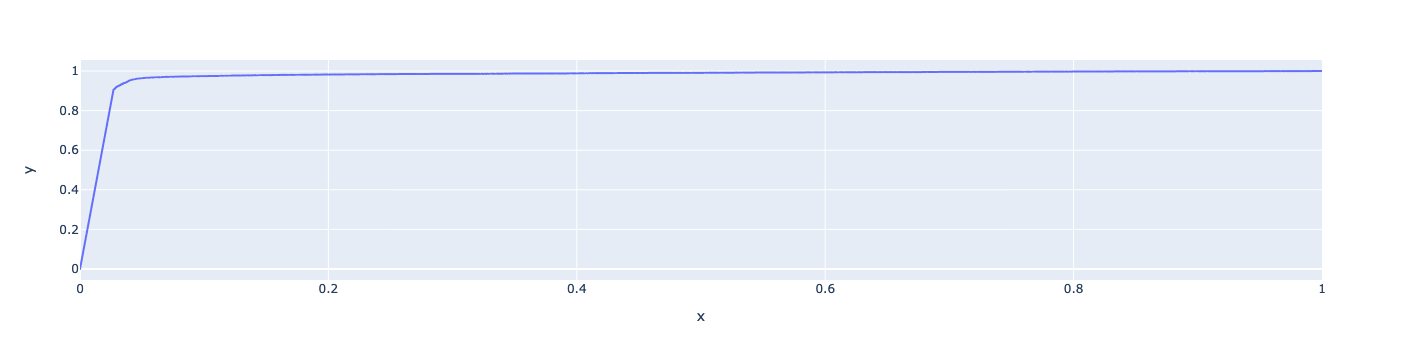

In [323]:
px.line(
    x=fpr,
    y=tpr
)

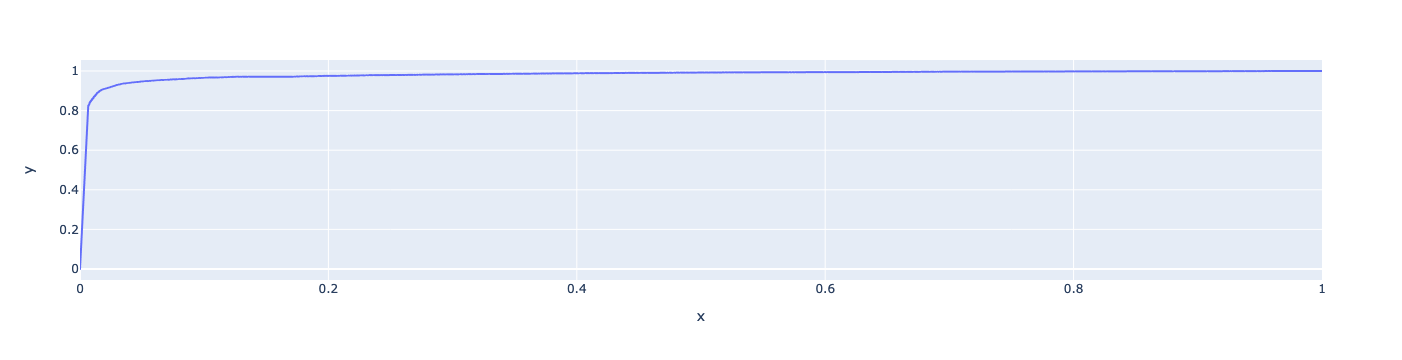

In [313]:
px.line(
    x=fpr,
    y=tpr
)

  0%|          | 0/4 [00:00<?, ?it/s]

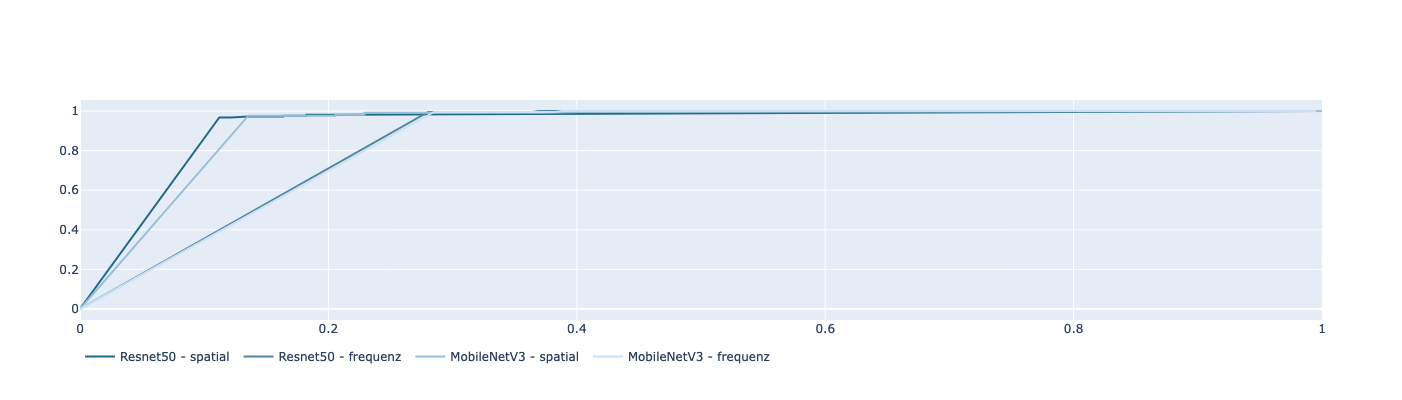

In [281]:
get_roc_figure(
    data.loc[(data.dataset == 'test') & (data.dpi == '300')],
    get_tile_results=True
)

  0%|          | 0/2 [00:00<?, ?it/s]

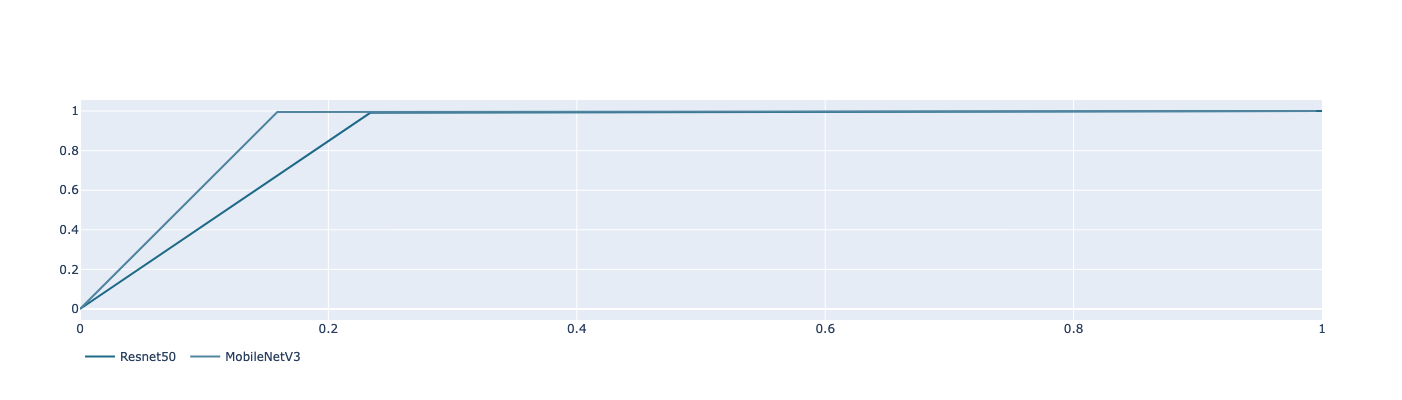

In [276]:
get_roc_figure(
    compare_model_results,
    get_tile_results=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

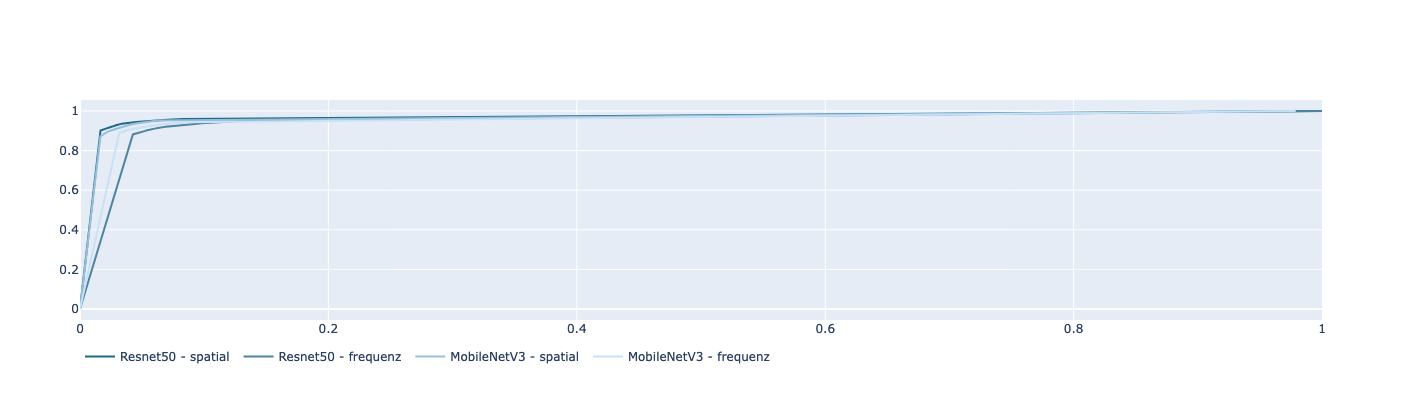

In [282]:
get_roc_figure(
    data.loc[(data.dataset == 'test') & (data.dpi == '300')]
)

  0%|          | 0/2 [00:00<?, ?it/s]

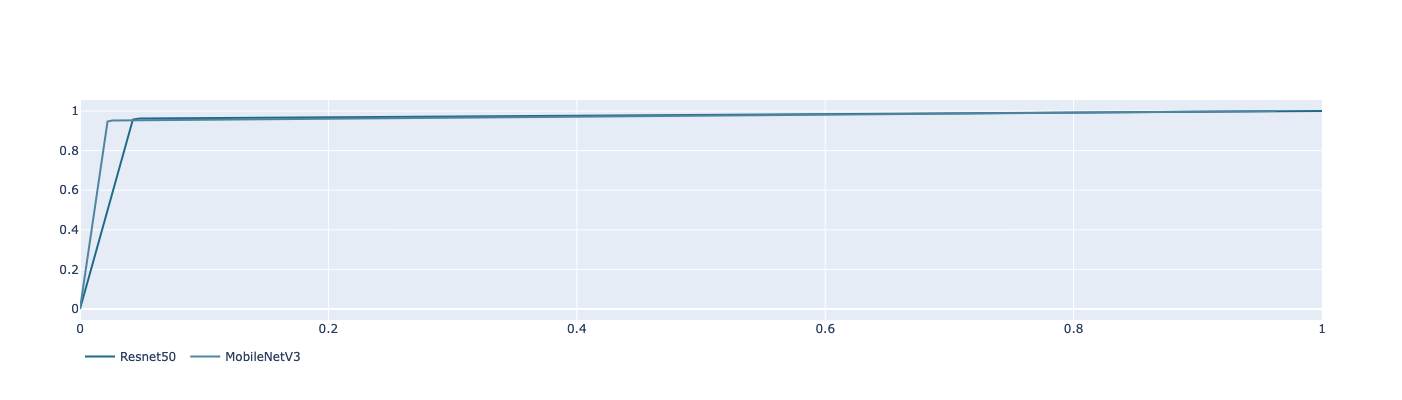

In [277]:
get_roc_figure( compare_model_results )

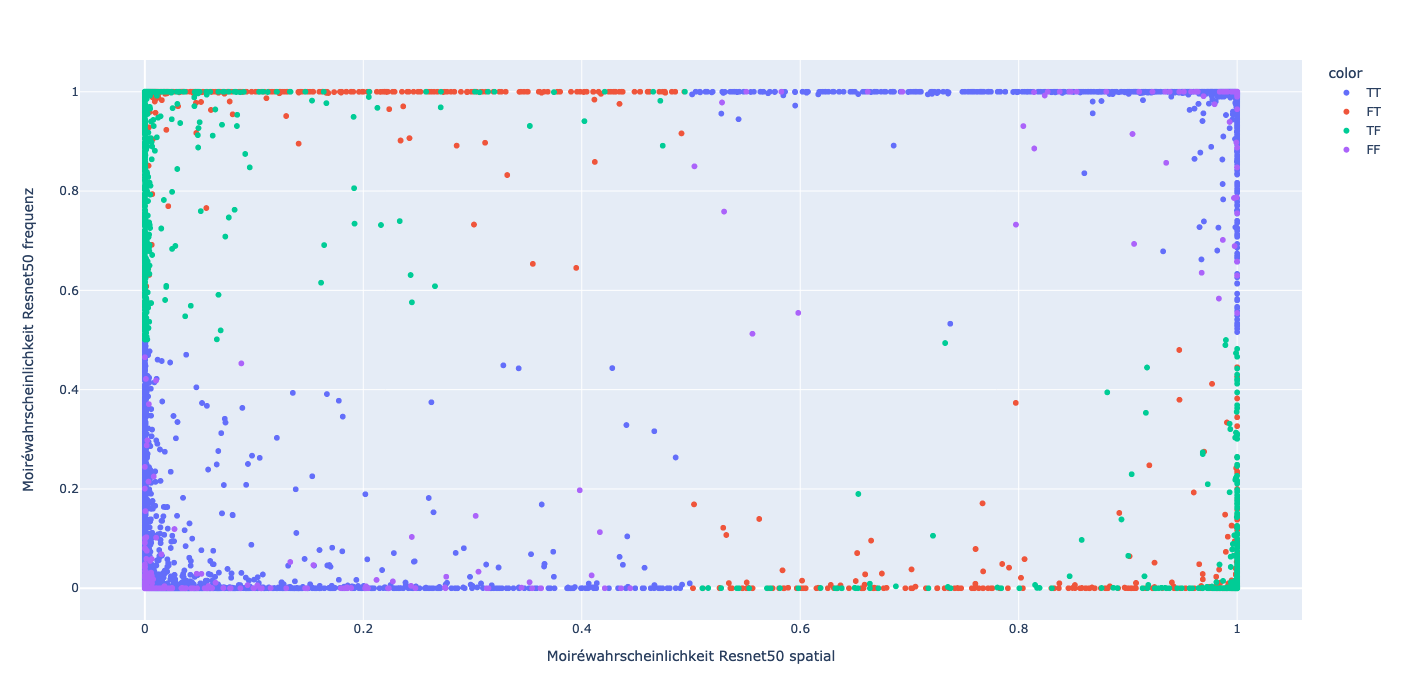

In [218]:
px.scatter(
    x=compare_model_results.result_moire_a,
    y=compare_model_results.result_moire_b,
    color=compare_model_results.result_group,
    height=700,
    width=700,
    labels={
        'x' : 'Moiréwahrscheinlichkeit Resnet50 spatial',
        'y' : 'Moiréwahrscheinlichkeit Resnet50 frequenz'
    }
)

# Rest

In [ ]:
grouped_by_tilename = data.loc[
    data.dataset == 'real_val',
    ['tile_name','label','mask_id']
].groupby(['tile_name','label']).count().rename(columns={'mask_id':'total_count'})

grouped_by_tilename.loc[
    :,
    'classification_correct'
] = data.loc[
    data.dataset == 'real_val',
    ['tile_name','label','classification_correct']
].groupby(['tile_name','label']).sum().classification_correct

# Auswertung nach erkannten Kacheln

In [ ]:
dataset = 'real_val'

tile_names = data.loc[
    data.dataset == dataset
].tile_name.unique()

tile_result_frame = data.loc[
    data.dataset == dataset,
    ['tile_name','model_name','classification_correct']
].set_index(['tile_name','model_name']).unstack('tile_name')
tile_result_frame.columns = [c[1] for c in tile_result_frame.columns]

tile_result_frame = tile_result_frame.T

In [ ]:
from PIL import Image

In [ ]:
n = 2

In [ ]:
grouped_models = data.loc[
    (data.dataset == 'real_val') &
    (data.model_name.isin(["2024-05-10_Resnet50_004","2024-05-13_Resnet50_004"])),
    ['tile_name','result_moire','result_no_moire']
].groupby('tile_name').max()

grouped_models.loc[
    :,
    'label'
] = data.loc[
    (data.dataset == 'real_val') &
    (data.model_name.isin(["2024-05-10_Resnet50_004","2024-05-13_Resnet50_004"])),
    ['tile_name','label']
].groupby('tile_name').first().label

grouped_models.loc[
    grouped_models.result_moire > grouped_models.result_no_moire,
    'predicted_label'
] = 'moire'
grouped_models.predicted_label.fillna("no_moire", inplace=True)
grouped_models.loc[:,'classification_correct'] = grouped_models.label == grouped_models.predicted_label

In [ ]:
tile_result_frame.loc[:,'2024-05-10_Resnet50_004'].sum(), tile_result_frame.loc[:,'2024-05-13_Resnet50_004'].sum()

In [ ]:
tile_result_frame.shape

In [ ]:
grouped_models.classification_correct.sum()

In [ ]:
def get_model_confusion_data( model_a, model_b ):
    results = []

    for result_a in [True,False]:
        row = []
        results.append(row)
        
        for result_b in [True,False]:
            row.append(
                tile_result_frame.T.loc[
                    (tile_result_frame.T[model_a] == result_a) &
                    (tile_result_frame.T[model_b] == result_b)
                ].shape[0]
            )

    return pd.DataFrame(
        results,
        index=[True,False],
        columns=[True,False]
    )

def get_model_confusion_matrix( model_a, model_b, is_relative=False ):
    data = get_model_confusion_data( model_a, model_b )
    
    if is_relative:
        data = (data / data.sum().sum()).round(3)
    
    return px.imshow(
        data,
        text_auto=True,
        labels={
            'y' : model_a,
            'x' : model_b
        }
    )

In [ ]:
get_model_confusion_matrix(
    '2024-05-10_Resnet50_004',
    '2024-05-13_Resnet50_004',
    is_relative=True
)

In [ ]:
data_selection = data.loc[
    (data.tile_name.isin(
        tile_result_frame.loc[
            (tile_result_frame['2024-05-10_Resnet50_004'] == False) &
            (tile_result_frame['2024-05-13_Resnet50_004'])
        ].index
    )) &
    (data.model_name.isin(['2024-05-10_Resnet50_004','2024-05-13_Resnet50_004'])),
    ['tile_name','model_name','result_moire']
].set_index(['tile_name','model_name']).unstack('model_name')
data_selection.columns = [c[1] for c in data_selection.columns]

data_selection

In [ ]:
px.scatter(data_selection.iloc[:250])

# Rest

In [ ]:
get_tile_result_grid(
    data.loc[
        (data.label == 'moire') &
        (data.predicted_label == 'no_moire') &
        (data.dataset == 'real_val')
    ].sample(frac=1).iloc[:25],
)

In [ ]:
result

In [ ]:
result = data.iloc[0]

In [ ]:
px.line(
    data.loc[
        (data.label == 'moire') &
        (data.predicted_label == 'no_moire') &
        (data.dataset == 'train')
    ].sort_values('result_moire').reset_index().result_moire
)

In [ ]:
data.loc[
    (data.label == 'moire') &
    (data.predicted_label == 'moire') &
    (data.dataset == 'train')
].sort_values('result_moire', ascending=False).iloc[:50]

In [ ]:
get_tile_result_grid(
    data.loc[
        (data.label == 'moire') &
        (data.predicted_label == 'moire') &
        (data.dataset == 'train')
    ].sort_values('result_moire', ascending=False).iloc[:50],
)

In [ ]:
def get_tile_result_grid( data, img_size=224, col_count=5, label_type='both' ):
    label_names = ['moire','no_moire']
    row_count = math.ceil(data.shape[0] / col_count)

    out_img = Image.new(
        'RGB',
        (img_size * col_count, img_size * row_count),
        color="white"
    )
    draw = ImageDraw.Draw(out_img)  
    label_color=[
        (0,200,0),
        (200,0,50)
    ]

    for i in range(data.shape[0]):
        row = i // col_count
        col = i % col_count

        result = data.iloc[i]
        tile_path = dotenv['TILE_DATASET_DIR'] / dataset_name / result.dataset / result.label / result.tile_name
        tile_img = Image.open( tile_path )
        out_img.paste(
            tile_img,
            ( col * tile_img.size[0], row * tile_img.size[1] )
        )
        draw.rectangle(
            (
                ( col * tile_img.size[0], row * tile_img.size[1] + round(img_size * 0.9) ),
                ( col * tile_img.size[0] + img_size, row * tile_img.size[1] + img_size )
            ),
            outline=None,
            fill=label_color[0] if result.classification_correct else label_color[1]
        )

        if label_type == 'label_name':
            label_text = f'{ result.predicted_label }/{ result.label }'
        elif label_type == 'moire_value':
            label_text = str( round(result.result_moire, 5) )
        else:
            label_text = f'{ result.predicted_label }/{ result.label } - {round(result.result_moire, 5)}'
        
        draw.text(
            ( col * tile_img.size[0] + round(img_size * 0.5), row * tile_img.size[1] + round(img_size * 0.97) ),
            label_text,
            anchor='ms',
            font_size=15
        )
    
    return out_img

In [ ]:
results = []

for tile_path in tqdm(tile_paths):
    tile = Image.open(tile_path)
    transform = transforms.Compose([transforms.PILToTensor()])

    tensor = transform(tile) / 255
    tensor = tensor.reshape((1,3,224,224))
    with torch.no_grad():
        pred = model(tensor)

    results.append((
        tile_path,
        pred,
        int(torch.argmax(pred))
    ))

In [ ]:
font = ImageFont.load_default()

In [ ]:
IMG_SIZE = 224

label_names = ['moire','no_moire']
grid_size = (5,5)

offset = 0

while offset < len(results):
    out_img = Image.new(
        'RGB',
        (IMG_SIZE * grid_size[0], IMG_SIZE * grid_size[1]),
        color="white"
    )
    draw = ImageDraw.Draw(out_img)  
    label_color=[
        (0,200,0),
        (200,0,50)
    ]
    
    for y in range(grid_size[1]):
        for x in range(grid_size[0]):
            i = y * grid_size[1] + x
    
            if len(results) > offset + i:
                result = results[offset+i]
                label = result[0].parent.name
                target_label = label_names[result[2]]
                
                tile_img = Image.open( result[0] )
                out_img.paste(
                    tile_img,
                    ( x * tile_img.size[0], y * tile_img.size[1] )
                )
                draw.rectangle(
                    (
                        ( x * tile_img.size[0], y * tile_img.size[1] + round(IMG_SIZE * 0.9) ),
                        ( x * tile_img.size[0] + IMG_SIZE, y * tile_img.size[1] + IMG_SIZE )
                    ),
                    outline=None,
                    fill=label_color[0] if label == target_label else label_color[1]
                )
                draw.text(
                    ( x * tile_img.size[0] + round(IMG_SIZE * 0.5), y * tile_img.size[1] + round(IMG_SIZE * 0.97) ),
                    f'{ label }/{ target_label }',
                    anchor='ms',
                    font_size=15
                )
                
    offset += 50
    out_img.save( f'/Users/frederic.birwe/Downloads/tile_grid_{ (str(offset)).zfill(3) }.jpg' )

out_img

In [ ]:
results